In [396]:
# Get plot data

import json
def getPlotData(fileName, data_type):
    with open(fileName, 'r') as file:
        data_all_a = json.load(file)

    y_x_a = []
    if data_type=='m_unc':
        for data in data_all_a:
            total = float(data["Packets"]["Unconfirmed"])
            success = float(data["Packets"]["UnconfirmedSuccess"])
            if total>0:
                d = (success/total,total/float(data["SimTime"]))
                y_x_a.append(d)
    elif data_type=='m_c':
        for data in data_all_a:
            total = float(data["Packets"]["Confirmed"])
            success = float(data["Packets"]["ConfirmedSuccess"])
            if total>0:
                d = (success/total,total/float(data["SimTime"]))
                y_x_a.append(d)
    elif data_type=='cpsr':
        for data in data_all_a:
            total = float(data["CPSR"]["Total"])
            success = float(data["CPSR"]["Success"])
            if total>0:
                d = (success/total,total/float(data["SimTime"]))
                y_x_a.append(d)
    elif data_type=='saturated_gw':
        for data in data_all_a:
            total = float(data['Metrics']['S']) + float(data['Metrics']['U']) + float(data['Metrics']['I']) + float(data['Metrics']['R']) + float(data['Metrics']['T'])
            success = float(data["Metrics"]["R"])
            total_packets = float(data["ULPDR"]["Total"])
            if total > 0:
                d = (success/total,total_packets/float(data["SimTime"]))
                y_x_a.append(d)
    else:
        for data in data_all_a:
            d = (float(data["ULPDR"]["Success"])/float(data["ULPDR"]["Total"]),float(data["ULPDR"]["Total"])/float(data["SimTime"]))
            y_x_a.append(d)

    y_x_a.sort(key=lambda x: x[1])

    y = [d[0] for d in y_x_a]
    x = [d[1] for d in y_x_a]
    return x,y

In [397]:
# Filter using z-scores

import numpy as np

def find_outliers_zscore(x, y, l_threshold=0.1, h_threshold=5):

    x = np.array(x)
    y = np.array(y)

    z_scores_y = np.abs((y - np.mean(y)) / np.std(y))

    filtered_indices = np.where((z_scores_y > l_threshold) & (z_scores_y < h_threshold))[0]
    filtered = [(x[i], y[i]) for i in filtered_indices]

    return filtered


<b><ul><li>Polynomial Fit, no filtering</b>

In [398]:

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def create_plot(fileNamex, labelx, mixed_type, degree, line_style, marker_style):
    x,y = getPlotData(fileNamex, mixed_type)

    plt.xscale('log')

    df = pd.DataFrame({"X Values": x, "Y Values": y})
    
    coefficients = np.polyfit(df['X Values'], df['Y Values'], degree)
    polynomial = np.poly1d(coefficients)
    df['y_fitted'] = polynomial(df['X Values'])

    plt.plot(df['X Values'], df['y_fitted'], label=f'{labelx}', linestyle=line_style, marker=marker_style, color='black', markerfacecolor='None')

    plt.legend()

<h1>Class B devices</h1>
<hr><hr><hr><h3><li>1. Baseline Performance Analysis</li></h3><hr><hr><hr>

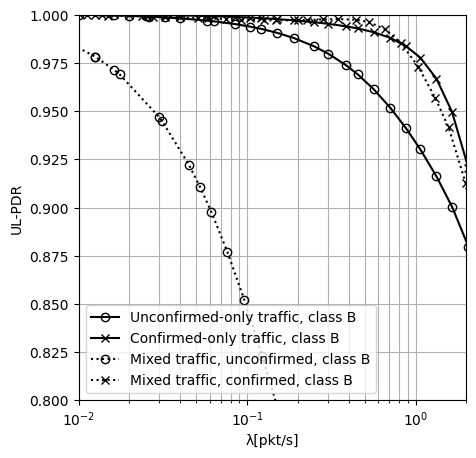

In [399]:
# Create plot for class b baseline analysis

create_plot('final_sim/test_scenario_baseline/True/ULPDR_UNCONFIRMED_B', 'Unconfirmed-only traffic, class B','unc',7,'-','o')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_B', 'Confirmed-only traffic, class B','unc',7,'-','x')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_B', 'Mixed traffic, unconfirmed, class B','m_unc',7,':','o')
create_plot('final_sim/test_scenario_baseline/True/ULPDR_MIXED_B', 'Mixed traffic, confirmed, class B','m_c',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,2])
plt.ylim([0.8,1])

plt.grid(True, which='both')
plt.show()

In [400]:

import matplotlib.pyplot as plt
import json

def get_bar_plot_data(fileName):
    with open(fileName, 'r') as file:
        data_all_a = json.load(file)
        s_count=0
        u_count=0
        i_count=0
        r_count=0
        t_count=0
        for data in data_all_a:
            s_count += float(data['Metrics']['S'])
            u_count += float(data['Metrics']['U'])
            i_count += float(data['Metrics']['I'])
            r_count += float(data['Metrics']['R'])
            t_count += float(data['Metrics']['T'])
        total = u_count+i_count+r_count+t_count
        y = [(u_count/total), (i_count/total), (r_count/total), (t_count/total)]
        
        return y

def generate_bar_plot(unc_file1, cn_file2, device_class):
    x = ['U', 'I', 'R', 'T']
    ulpdr_unconfirmed = get_bar_plot_data(unc_file1)
    ulpdr_confirmed = get_bar_plot_data(cn_file2)

    plt.figure(figsize=(10, 5))

    bar_width = 0.9

    bar_positions_set1= [2,6,10,14]
    bar_positions_set2= [3,7,11,15]

    plt.bar(bar_positions_set1, ulpdr_unconfirmed, width=bar_width, label='Unconfirmed', color='white', edgecolor='black', hatch='\\')
    plt.bar(bar_positions_set2, ulpdr_confirmed, width=bar_width, label='confirmed', color='white',edgecolor='black', hatch='.')

    # Add labels to the axes
    plt.ylabel('Fraction of lost packets (%)')
    plt.title(f'Class {device_class}')

    xtick_positions = [2.5, 6.5, 10.5, 14.5] 
    plt.xticks(xtick_positions, x)

    plt.legend()
    plt.ylim([0.0,1.0])
    plt.tight_layout()
    
    plt.grid(True, which='both')
    plt.show()

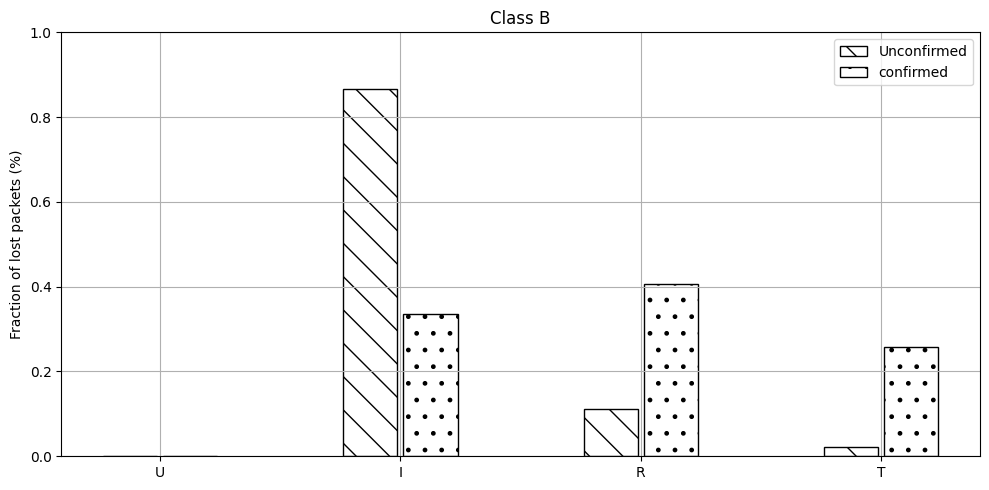

In [401]:
# Create bar plot for lost packets
generate_bar_plot('final_sim/test_scenario_baseline/True/ULPDR_UNCONFIRMED_B', 'final_sim/test_scenario_baseline/True/ULPDR_CONFIRMED_B', 'B')

<hr><hr><hr><h3><li>2. Gateway DC</li></h3></ol><hr><hr><hr>

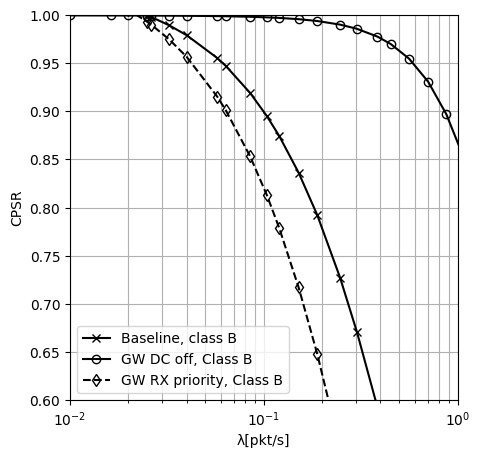

In [402]:

create_plot('final_sim/test_scenario_gw_dc_on_off/on/ULPDR_CONFIRMED_B', 'Baseline, class B', 'cpsr', 7, '-', 'x')
create_plot('final_sim/test_scenario_gw_dc_on_off/off/ULPDR_CONFIRMED_B', 'GW DC off, Class B', 'cpsr', 7, '-', 'o')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_B', 'GW RX priority, Class B', 'cpsr', 7, '--', 'd')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')  
plt.xlim([0.01,1])
plt.ylim([0.6,1.0])

plt.grid(True, which='both')
plt.show()

<hr><hr><hr><h3><li>3. Priority of Reception Over Transmission</li></h3></ol><hr><hr><hr>

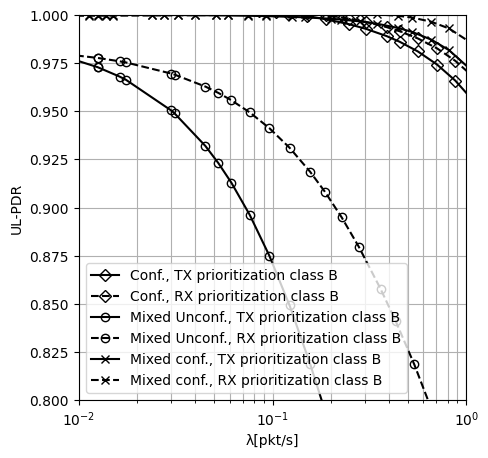

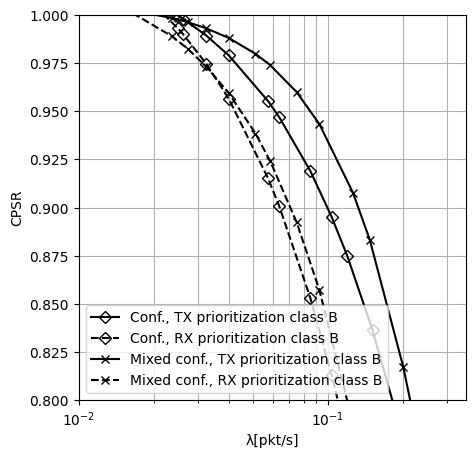

In [403]:
# Create plot for class b Rx priority analysis

create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_CONFIRMED_B', 'Conf., TX prioritization class B','unc',2,'-','D')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_B', 'Conf., RX prioritization class B','unc',2,'--','D')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_B', 'Mixed Unconf., TX prioritization class B','m_unc',5,'-','o')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_B', 'Mixed Unconf., RX prioritization class B','m_unc',5,'--','o')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_B', 'Mixed conf., TX prioritization class B','m_c',2,'-','x')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_B', 'Mixed conf., RX prioritization class B','m_c',2,'--','x')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,1])
plt.ylim([0.8,1.0])

plt.grid(True, which='both')
plt.show()

create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_CONFIRMED_B', 'Conf., TX prioritization class B','cpsr',7,'-','D')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_CONFIRMED_B', 'Conf., RX prioritization class B','cpsr',7,'--','D')
create_plot('final_sim/test_scenario_gw_tx_priority/True/ULPDR_MIXED_B', 'Mixed conf., TX prioritization class B','cpsr',7,'-','x')
create_plot('final_sim/test_scenario_gw_tx_priority/False/ULPDR_MIXED_B', 'Mixed conf., RX prioritization class B','cpsr',7,'--','x')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01,0.36])
plt.ylim([0.8,1.0])

plt.grid(True, which='both')
plt.show()

<hr><hr><hr><h3><li>4. Number of Transmission Attempts</li></h3></ol><hr><hr><hr>

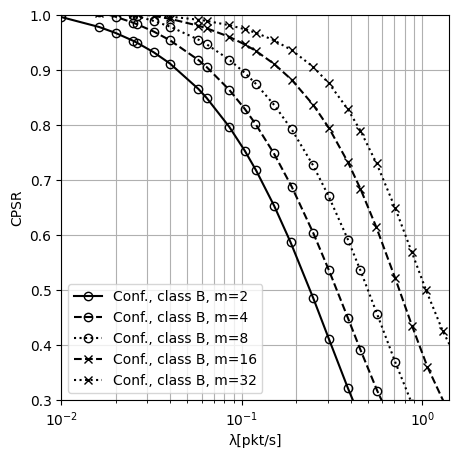

In [404]:
# Create plot for class b change of transmission attempts analysis

create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/2/ULPDR_CONFIRMED_B', 'Conf., class B, m=2','cpsr',7,'-','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/4/ULPDR_CONFIRMED_B', 'Conf., class B, m=4','cpsr',7,'--','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/8/ULPDR_CONFIRMED_B', 'Conf., class B, m=8','cpsr',7,':','o')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','cpsr',7,'--','x')
create_plot('final_sim/test_scenario_confirmed_traffic_retransmission_attempts/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','cpsr',7,':','x')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('CPSR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 1.4])
plt.ylim([0.3,1])

plt.grid(True, which='both')
plt.show()

<hr><hr><hr><h3><li>5. Number of Available Receive Paths</li></h3></ol><hr><hr><hr>

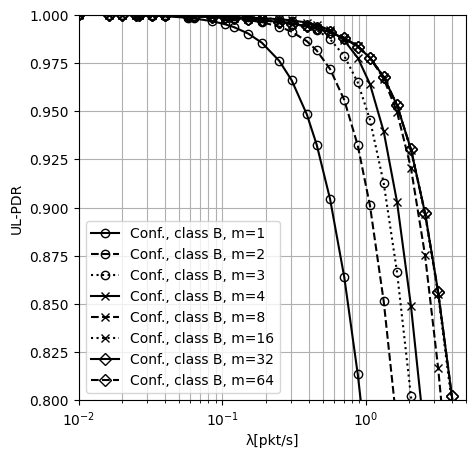

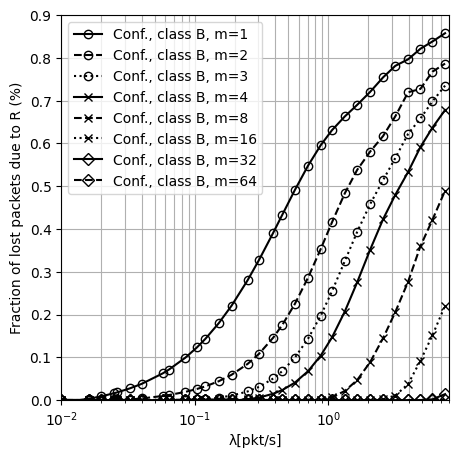

In [405]:
# Create plot for class b change of transmission attempts analysis


create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_CONFIRMED_B', 'Conf., class B, m=1','unc',7,'-','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_CONFIRMED_B', 'Conf., class B, m=2','unc',7,'--','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_CONFIRMED_B', 'Conf., class B, m=3','unc',7,':','o')
create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_CONFIRMED_B', 'Conf., class B, m=4','unc',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_CONFIRMED_B', 'Conf., class B, m=8','unc',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','unc',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','unc',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_CONFIRMED_B', 'Conf., class B, m=64','unc',7,'--','D')


f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('UL-PDR')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 5])
plt.ylim([0.8,1])
# plt.tight_layout()

plt.grid(True, which='both')
plt.show()



create_plot('final_sim/test_scenario_gw_parallel_paths/1/ULPDR_CONFIRMED_B', 'Conf., class B, m=1','saturated_gw',7,'-','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/2/ULPDR_CONFIRMED_B', 'Conf., class B, m=2','saturated_gw',7,'--','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/3/ULPDR_CONFIRMED_B', 'Conf., class B, m=3','saturated_gw',7,':','o')

create_plot('final_sim/test_scenario_gw_parallel_paths/4/ULPDR_CONFIRMED_B', 'Conf., class B, m=4','saturated_gw',7,'-','x')

create_plot('final_sim/test_scenario_gw_parallel_paths/8/ULPDR_CONFIRMED_B', 'Conf., class B, m=8','saturated_gw',7,'--','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/16/ULPDR_CONFIRMED_B', 'Conf., class B, m=16','saturated_gw',7,':','x')
create_plot('final_sim/test_scenario_gw_parallel_paths/32/ULPDR_CONFIRMED_B', 'Conf., class B, m=32','saturated_gw',7,'-','D')
create_plot('final_sim/test_scenario_gw_parallel_paths/64/ULPDR_CONFIRMED_B', 'Conf., class B, m=64','saturated_gw',7,'--','D')

f = plt.gcf()
f.set_figwidth(5)  
f.set_figheight(5)
plt.ylabel('Fraction of lost packets due to R (%)')
plt.xlabel('λ[pkt/s]')
plt.xlim([0.01, 8])
plt.ylim([0.0,0.9])
# plt.tight_layout()

plt.grid(True, which='both')
plt.show()